<h1>Hands On: Dimensionality Reduction.</h1>

A veces nos encontramos con modelizaciones en las que interviene un número demasiado grande de variables como para ser modelizadas de forma bruta. Para ello existen técnicas de reducción de la dimensionalidad, como las que vamos  a ver en este notebook. Los puntos que se van a tratar en este notebook son los siguientes:

  - The Curse of Dimensionality.
  - Técnicas generales de reducción de dimensionalidad: Projection y Mainfold Learning.
  - PCA.
  - Kernel PCA. 
  - LLE.
  - Otras técnicas de reducción de dimensionalidad.
  
Las técnicas de reducción de dimensionalidad nos permiten acelerar muchísimo los entrenamientos de modelos (a costa de perder información, es decir, que sean menos precisos), y permiten visualizar la información de una forma mucho más sencilla. El objetivo de este notebook es conocer y comprender las técnicas más usuales de reducción de dimensionalidad para aquellos sistemas que tengan un número muy elevado de variables.

<h3>Imports</h3>

In [1]:
# Imports generales:
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_swiss_roll
from sklearn.metrics import mean_squared_error

# Algoritmos:
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.manifold import LocallyLinearEmbedding

# Para esconder los warning:
import warnings
warnings.filterwarnings('ignore')

<h2>The Curse of Dimensionality</h2>

Las personas vivimos en un mundo tridimensional, por eso nos cuesta imaginar espacios con una dimensionalidad mayor. Además, cuanto mayor sea la dimensionalidad de un espacio, mayor es la dispersión que existe entre los elementos del mismo. Esto hace que las predicciones en un espacio de muchas dimensiones sean mucho menos precisas. Cuanto mayor es el espacio del training set, más probable es hacer overfitting.

Una solución lógica sería aumentar el tamaño del dataset para alcanzar una densidad suficiente de datos. El problema es que el número de instances necesarias para una densidad concreta aumenta exponencialmente con el número de variables, lo que para datasets de bastantes variables esto se vuelve impracticable. 

Por esto, la solución más sensata suele ser la reducción de la dimensionalidad.

<h2>Técnicas generales de reducción de dimensionalidad</h2>

Antes de ver los algoritmos de reducción de dimensionalidad, vamos a echarle un ojo a las dos principales técnicas de reducción de la dimensionalidad: Projection y Manifold Learning.

<h3>Projection</h3>

En la mayoria de los problemas del mundo real, las instances no se distribuyen uniformemente en todas las dimensiones. Muchas features son constantes, otras están fuertemente correlacionadas, etc. Como resultado, la mayoria de instances se aproximan a un subespacio de una dimensión menor (es reducir una dimensión, por ejemplo de un espacio 3d a un plano).

Esta reducción de dimensionalidad es buena cuando los datos son "planos". Es decir, si los datos representan una curva en el espacio que se quiere reducir, se perderá mucha información al reducir la dimensión.

<h3>Manifold Learning</h3>

Para los casos en los que exista curvatura en la distribución de los datos (por ejemplo un Swiss roll) no se debe proyectar sobre un subespacio menor. Para ello se utiliza la técnica de manifold o desenrollado. Un d-dimension manifold es una parte de un n-dimensional space que localmente se puede reestructurar en un d-dimensional hyperplane.

Muchos algoritmos de reducción de dimensiones modelizan el manifold de las instances. Esto es llamado Manifold Learning. Esto se basa en la hipótesis de que la mayor parte de los datasets de alta dimensionalidad del mundo real pueden ceñirse en torno a manifolds de muchas menos dimensiones (manifold assumption). Esta hipótesis es comúnmente observada (pero solo de fomra empírica, no hay una demostración numérica).

Dicho de otro modo, se pueden encontrar constraints sobre los datos de un dataset que reducen su dimensionalidad. Por ejemplo, en el MNIST (números) todas las imágenes están hechas de líneas conectadas, los bordes son blancos, están (más o menos) centradas, etc. Al final, se reducen drásticamente los grados de libertad, lo que permite comprimir el dataset en un manifold de mucha menor dimensionalidad.

La manifold assumption suele venir acompañada de otra asumpción: la tarea a realizar (p.e. regresión o clasificación) es más simple si se expresa en este manifold de menor dimensión. Sin embargo, esta segunda asumpción no siempre se cumple.

Vámos a ver algunos de los algoritmos utilizados para hacer la reducción de dimensionalidad:

<h2>PCA        -       Proyección</h2>

El algoritmo PCA (Principal Component Analysis) es el algoritmo de reducción de dimensionalidad más utilizado. Conceptualmente, primero encuentra el hiperplano que mejor aproxima a los datos y después proyecta sobre él.

Para escoger el hiperplano correcto, se utiliza el argumento de preservar la mayor varianza posible. Esto es similar a decir que se escoge aquel hiperplano que minimiza la distancia (mean squared distance) entre el dataset original y la proyección. Esta es la idea fundamental del PCA.

El vector que define los i ejes del hiperplano sobre el que se va a proyectar se llama vector de componentes principales. La forma de encontrarlo es utilizaar el SVD (Singular Value Decomposition) que descompone la matriz del training set X en la multiplicación de tres matrices U E V^T, donde V es la matriz de componentes principales:

    V = (c_1 c_2 c_3 ...)      con c_i la componente principal del eje i
    
Nota: PCA asume que el dataset está centrado sobre el origen. El algoritmo que se verá de Sklearn lo centra automáticamente, pero si se hace uno es importante centrar los datos.    

Este método, el SVD, está implementado de forma genérica en Numpy:

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

# Se centran los datos para PCA:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

Una vez se han encontrado los componentes principales, se puede reducir la dimensionalidad del dataset a d dimensiones proyectandolo sobre el hyperplane definido por las d componentes principales:

    X_d-proj = X * W_d

In [3]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D_using_svd = X2D

Usando Sklearn es mucho más sencillo, ya que sigue la misma estructura de todas las clases de Sklearn (objeto, metodo fit_transform, etc).

In [4]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

# Vamos a comprobar que es igual:
print ('Ejemplo de vector con el método de Numpy: ')
print (X2D[:5])
print ('')

print ('Ejemplo de vector con el método de Sklearn: ')
print (X2D_using_svd[:5])
print ('')


# Los componentes principales se pueden sacar con el siguiente atributo:
print ('Los componentes principales son: ')
print (pca.components_)

# Para recuperar el vector original se usa el método X3D_inv = pca.inverse_transform(X2D)
# No recupera exactamente el mismo vector porque hay pérdida de información.

Ejemplo de vector con el método de Numpy: 
[[ 1.26203346  0.42067648]
 [-0.08001485 -0.35272239]
 [ 1.17545763  0.36085729]
 [ 0.89305601 -0.30862856]
 [ 0.73016287 -0.25404049]]

Ejemplo de vector con el método de Sklearn: 
[[-1.26203346 -0.42067648]
 [ 0.08001485  0.35272239]
 [-1.17545763 -0.36085729]
 [-0.89305601  0.30862856]
 [-0.73016287  0.25404049]]

Los componentes principales son: 
[[-0.93636116 -0.29854881 -0.18465208]
 [ 0.34027485 -0.90119108 -0.2684542 ]]


La varianza explicada por cada uno de los componentes principales se puede obtener también con el atributo explained_variance_ratio_ . La varianza total que se conservará con la transformación del dataset será la suma de las varianzas de cada componente principal.

In [5]:
# La varianza recogida por cada componente viene en el siguiente atributo:
print('La varianza de los componentes es la siguiente: ')
print(pca.explained_variance_ratio_)

La varianza de los componentes es la siguiente: 
[0.84248607 0.14631839]


En estos ejemplos que hemos visto hemos predefinido el número de componentes principales. Pero, ¿cómo elegir el número de una forma correcta y automática? Para ello basta con definir el porcentaje de varianza mínimo que se desea conservar (excepto si es para visualización, que entonces hay que reducir a 2-3 variables).

El siguiente código hace el PCA sin reducir la dimensionalidad, y después computa el mínimo de dimensiones necesarias para preservar el 95% de la varianza:

In [6]:
# Utilizamos para el ejemplo los datos del MNIST: 
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)
X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# El algortimo para seleccionar la dimension necesaria: 
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

print ('El número de dimensiones que preservan el 95% de la varianza es: ',d)

El número de dimensiones que preservan el 95% de la varianza es:  154


Una vez obtenido el número de dimensiones se puede hacer un fit_transform con el n_components=d y ya se tendría el PCA hecho. 

Sin embargo, hay una forma mucho mas inmediata en Sklearn. El parámetro n_componentes permite dos tipos de inputs: un número entero para definir cuantas dimensiones se quieren utilizar en el PCA, y un número decimal entre 0.0 y 1.0 para definir la varianza mínima a mantener. Ejemplo:

In [7]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
print ('El número de dimensiones que preservan el 95% de la varianza es: ',pca.n_components_)

El número de dimensiones que preservan el 95% de la varianza es:  154


Por último, se puede utilizar un método visual. Si se grafica el número de dimensiones frente a la varianza explicada, se suele obtener un codo que determina las dimensiones que interesa utilizar en el PCA:

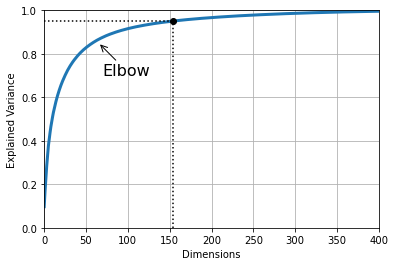

In [8]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

Una de los usos interesantes del PCA es comprimir los datos. En el ejemplo de antes (MNIST) se ha pasado de 748 features a solo 154 mientras se mantiene el 95% de la varianza: una reducción de casi el 80% del tamaño del set. Esto permite acelerar muchísimo los algortimos de clasificación.

En Sklearn es posible descomprimir el dataset a sus dimensiones previas usando el método inverse_transform(). Esto no da el dataset original, ya que al comprimir hay pérdida de información, pero se le acerca bastante. La distancia (mean squared distance) entre el dataset original y el descomprimido se llama error de reconstrucción. Para encontrar la expresión analítica basta con darle la vuelta a la expresión del PCA:

    X_recovered = X_d-proj * W_d^T


Existe un algoritmo (implementado en Sklearn con el hiperparámetro svd_solver='randomized') que encuentra una aproximación rápida a los componentes principales por medio de un proceso estocástico. Es muchísimo más rápido que un SVD completo cuando el número de componentes principales d es mucho menor que el número total de atributos m.

ejemplo: rnd_pca = PCA(n_components=154, svd_solver="randomized")

Por defecto, Sklearn tiene el svd_solver puesto como "auto": usa el randomized PCA si m es mayor que 500 y d es menor del 80%. En otro caso usa el full (de hecho, si se quiere forzar a hacer el full, hay que poner svd_solver='full').

El problema de los PCA anteriores es que tienen que almacenar en memoria todo el training set para correr el algoritmo. Para solucionarlo existe el Incremental PCA (IPCA), que divide el set en pequeños mini-batches y los entrena uno a uno. Esto se usa en datasets grandes y en PCA online.

Un ejemplo de como se usa en Sklearn para el MNIST:

In [9]:
n_batches = 100
inc_pca = IncrementalPCA(n_components=100)
for X_batch in np.array_split(X_train,n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

# Ejemplo usando numpy: para no importar un archivo "filename" pero si entrenar sobre el

# X_mm = np.memmap(filename, dtype="float32",mode="readonly",shape=(m,n))
# batch_size = m // n_batches
# inc_pca = IncrementalPCA(n_components=154,batch_size=batch_size)
# inc_pca.fit(X_mm)

<h2>Kernel PCA</h2>

En el notebook de Support Vector Machines se discutió el "Kernel Trick". Esta es una técnica que implícitamente mapea las instancias en un espacio de dimensión muy alta, permitiendo la clasificación no lineal y la regresión con SVMs. Como detalle, una boundary lineal en un espacio superior corresponde a una boundary no lineal (y compleja) en el espacio original.

El mismo truco se puede usar al PCA, haciendo posibles proyecciones complejas y no lineales para la reducción de dimensiones. Este es el Kernel PCA (o kPCA). Es bueno preservando clusters despues de las proyecciones e incluso "unrolling" datasets que caen cerca de un "twisted manifold". 

Un ejemplo en Sklearn es el siguiente:

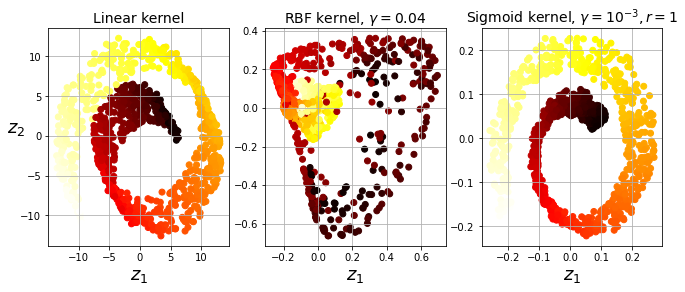

In [10]:
# Hacemos unos datos tipo swiss roll:

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

# Se hace el Kernel PCA:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)


# Vamos a ver un ejemplo descomponiendolo con distintos tipos de kernel:


lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

Como el kPCA es un algoritmo no supervisado, no hay una métrica obvia para ayudar a seleccionar los hiperparámetros o el mejor kernel. Sin embargo, la dimensión de reduccionalidad suele ser un paso previo para entrenar un algoritmo supervisado, asi que se puede hacer un grid search y seleccionar el kernel y el hiperparámetro que lleve a la mejor performance del supervisado. 

Por ejemplo el siguiente código de Sklearn:

In [11]:
clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

# Los mejores hiperparámetros y kernel son:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


Otra aproximación (totalmente no supervisada) es seleccionar el kernel y los hiperparámetros que den el menor error de reconstrucción. Sin embargo, a veces la reconstrucción no es tan sencilla como en un PCA lineal. Esto se debe a que el Kernel Trick computa un espacio de "infinitas dimensiones", por lo que no se puede hacer una reconstrucción real. La única aproximación posible es encontrar puntos en el espacio original que mapeen cerca del punto reconstruido (se llama pre-imagen). Con esta pre-imagen se puede medir la "squared distance" a la instancia original. Con esto se puede seleccionar el kernel y los hiperparámetros que minimizan el error de reconstrucción pre-imagen.

Para hacer esta reconstruccion (por ejemplo) se puede entrenar un modelo de regresión, con las instancias proyección como el training set y las instancias originales como el target. Esto lo hace Sklearn solo con el fit_inverse_transform=True. Una vez hecho esto, se puede utilizar Grid Search con Cross Validation para encontrar los kernel y hiperparámetros que minimizan el error de reconstrucción pre-image:

In [12]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

mean_squared_error(X, X_preimage)

32.786308795766125

<h2>LLE - Manifold Learning</h2>

Otra técnica de reducción de dimensionalidad no lineal (NLDR) muy potente es Locally Linear Embedding (LLE). Es una técnica Manifold, no depende de proyecciones como las técnicas anteriores. Resumiendo, LLE mide cómo de cerca está una instancia de sus closest neighbors, y buscando una representación de menor dimensión del training set que preserve esa relación. Es particularmente bueno desenrollando "twisted manifolds".

Un ejemplo desenrollando el Swiss roll:

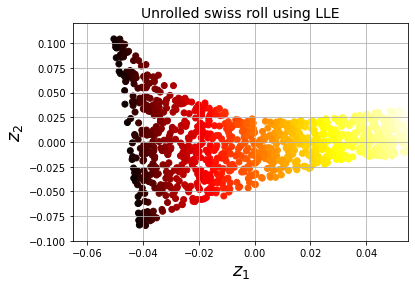

In [13]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

En detalle, el LLE funciona de la siguiente forma: para cada instancia x^(i) el algoritmo identifica los k closest neighbors (antes k=10) e intenta reconstruir x^(i) como una función lineal de esos 10 c.n.. Para ello, encuentra los pesos w_(i,j) tal que la squared distance entre x^(i) y sum(w_(i,j)*x^(j)) es la menor posible, asumiendo que w_(i,j) es distinto a 0 para los j que sean los 10 c.n e igual a 0 para el resto.

Así, las ecuaciones de constraint que definen el LLE son las siguientes:

    W = argmin( sum( x^(i) - sum(w_ (i,j) * x^(j) )
    
    sujeto a: w_(i,j)=0 si x^(j) no es un c.n. de x^(i)         w_(i,j)<>0 si es un c.n de x`(i)
    
Después de esto, la matriz W tendrá los pesos de w_(i,j) con las relaciones lineales entre las instances. El segundo paso es mapear las instances a un espacio d-dimensional donde d<n. Si z^(i) es la imagen de x^(i) en este espacio d, entonces buscamos que la distancia entre z^(i) y sum(w_(i,j)*z^(j)) sea la menor posible. La matriz Z viene dada por:

    Z = argmin ( sum (z^(i) - sum(w_(i,j) * z^(j))²
    
Sklearn tiene una implementacion de LLE con la siguiente complejidad computacional: O(m*log(m)*n log(k)) para encontrar los k nearest neighbors, O(m*n*k³) para optimizar pesos y O(d*m²) para construir la representacion. El último término escala fatal con datasets largos.

<h2>Otras técnicas de reducción de dimensionalidad</h2>

Existen muchos otros algoritmos de reducción de dimensionalidad, muchos disponibles en Sklearn. Algunos ejemplos:

- Multidimensional Scaling (MDS): reduce la dimensionalidad intentando mantener las distancias entre instancias.
- Isomap: crea un grafo conectando los nearest neighbors, y reduce la dimensionalidad intentando preservar las distancias geodésicas entre instancias.
- t-Distributed Stochastic Neighbor Embedding (t-SNE): reduce dimensionalidad intentando mantener instancias similares cerca, y instancias distintas alejadas. Se suele usar para visualizar clusters de instancias de espacios de alta dimension.
- Linear Discriminant Analisys (LDA): es un algoritmo de clasificación, pero en el entrenamiento se seleccionan los ejes más discriminantes, y se usan para definir un hiperplano sobre el que proyectar los datos. El beneficio es que esa proyección mantiene las clases lo mas alejadas posible, por lo que es una buena técnica para reducir dimensionalidad antes de usar otro algoritmo de clasificacion (p.e. un SVM).